In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import os
import numpy as np

In [2]:
data_dir = '/home/jing/Phd_project/project_UCD_blca/blca_DATA/blca_DATA_GSE135337/'
os.chdir(data_dir)

In [3]:
names_list = ["GSM4006644_BC1", "GSM4006647_BC4" ,"GSM4006648_BC5", "GSM4751267_BC6" ,"GSM4751268_BC7"]

GSM4006644_BC1


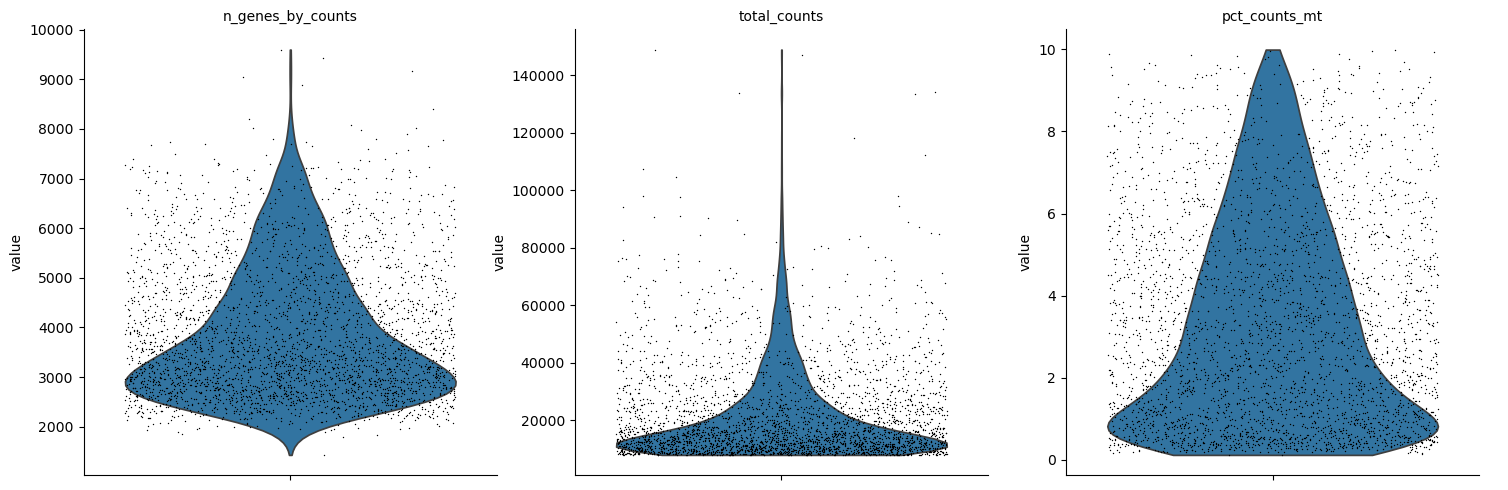

/tmp/ipykernel_2375444/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4006647_BC4


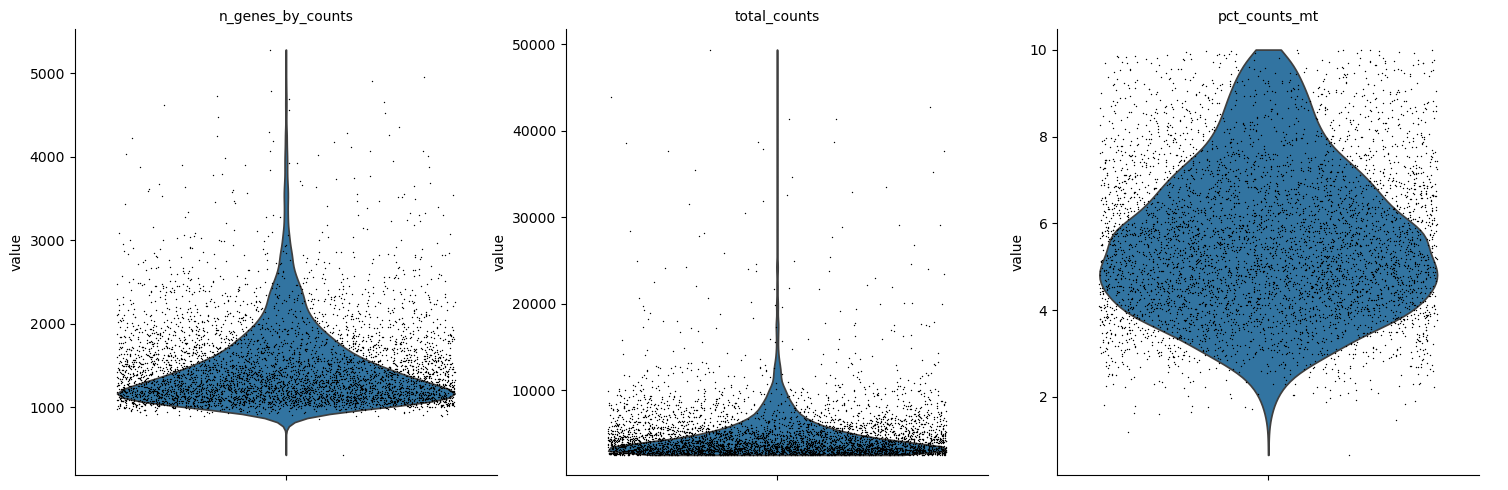

/tmp/ipykernel_2375444/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4006648_BC5


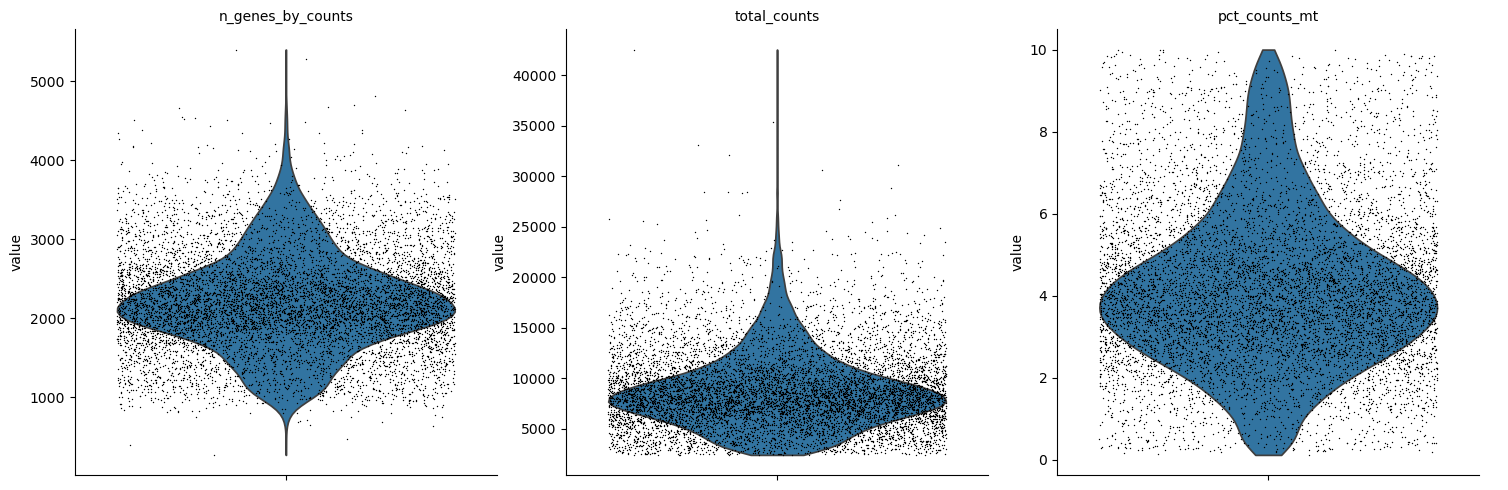

/tmp/ipykernel_2375444/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4751267_BC6


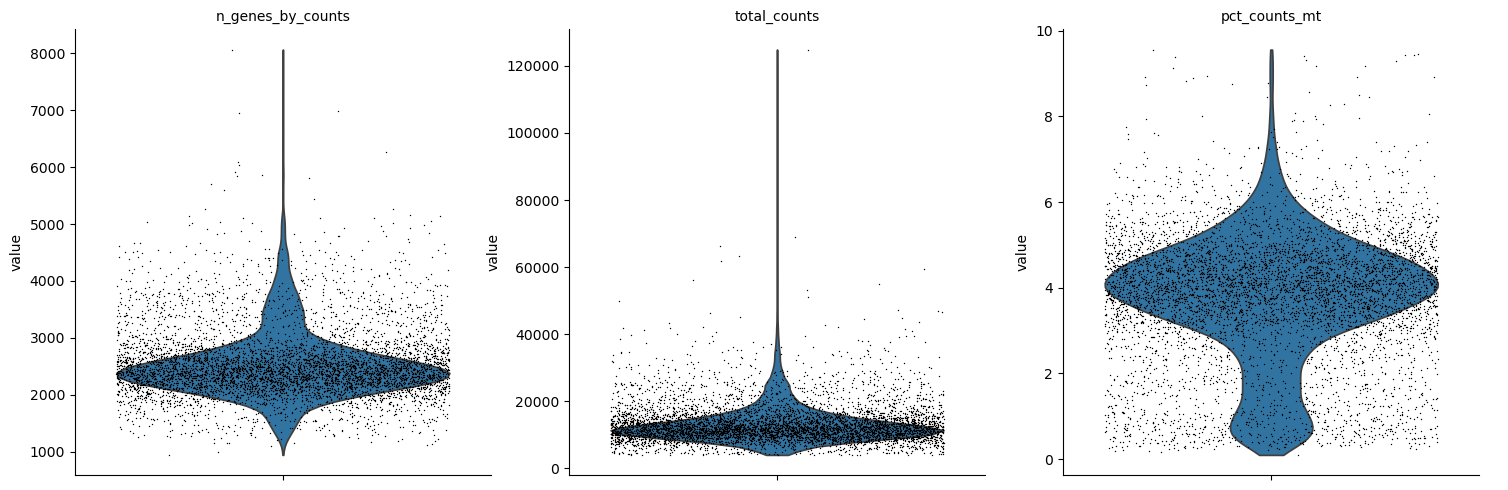

/tmp/ipykernel_2375444/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4751268_BC7


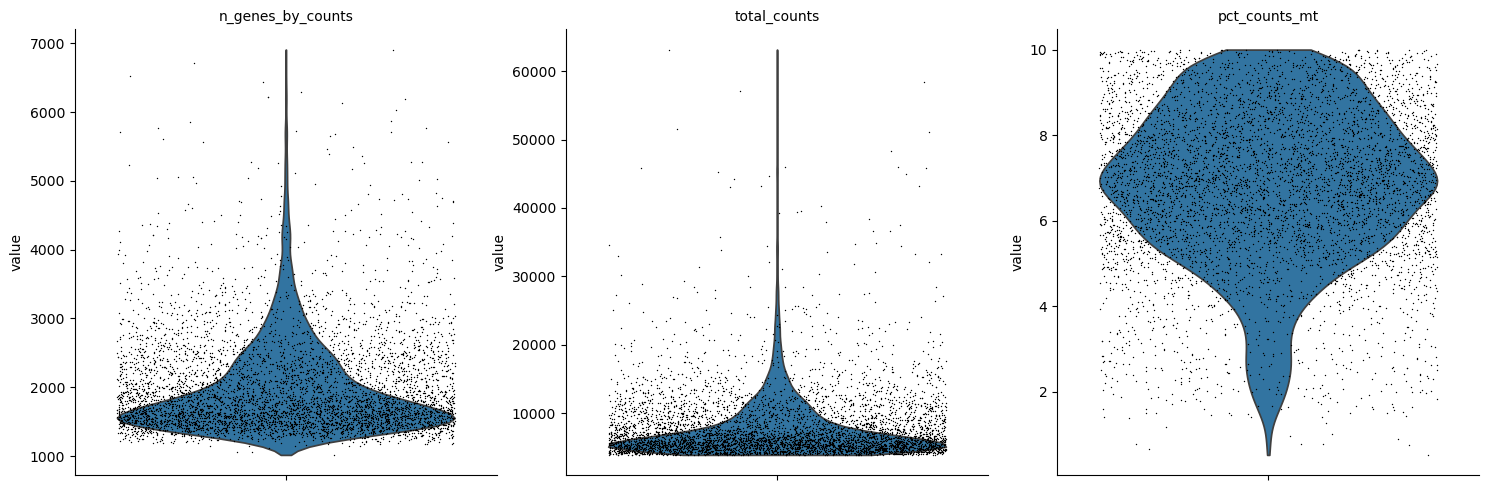

/tmp/ipykernel_2375444/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


In [4]:
adata_list = []

# Loop over each sample and read in the AnnData object
for name in names_list:
    file_path = f"{name}_gene_cell_exprs_table.txt.gz"
    df = pd.read_csv(file_path, sep='\t')
    df.index = df.iloc[:, 0]
    gene_symbols = df.iloc[:,:2]

    # Drop the first two columns (Ensembl ID and gene name)
    df = df.iloc[:, 2:]
    # Transpose so that cells are rows and genes are columns
    df = df.T

    adata = ad.AnnData(df)

    adata.obs['CellID']= df.index
    adata.var[['Ensemble_ID','Gene']]= gene_symbols
    adata.var.index= adata.var['Gene']
    adata.var_names_make_unique() 
    adata.var['mt'] =adata.var_names.str.startswith('MT-')

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.calculate_qc_metrics(adata,qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    print(name)
    sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True)
    
    adata= adata[adata.obs.n_genes_by_counts <6001, :]
    #adata= adata[adata.obs.pct_counts_mt< 5, :].copy()

    adata.obs['source'] = name
    adata.layers["counts"] = adata.X.copy()    

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata  # keep full dimension safe
    adata_list.append(adata)
    

In [5]:
batch_names = [adata.obs['source'].iloc[0] for adata in adata_list]
adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)                                  

/tmp/ipykernel_2375444/1379501109.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)


### Removed immune genes

In [6]:
immune_remove = pd.read_pickle('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/immune_cells_obs.pkl')
adata_non_immune = adata[~adata.obs.index.isin(immune_remove.index),]
adata_non_immune

View of AnnData object with n_obs × n_vars = 27864 × 13656
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM4751267_BC6', 'total_counts-GSM4751267_BC6', 'Ensemble_ID-GSM4751268_BC7', 'Gene-GSM4751268_BC7', '

### Combine 2000HVGs and LINCs genes

In [7]:
wkdir= "/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_LINCS/"
data_year = "2020"
cell_name = "BC3C"

data_dir = os.path.join(wkdir,"00_outputs_" + data_year + "_" + cell_name)
data_file = os.path.join(data_dir, "Data_norm_" + data_year + "_" + cell_name+ ".xlsx")
Data_norm = pd.read_excel(data_file, index_col = 0)
display(Data_norm)

genes_list = Data_norm.columns.to_list()
print("Landmark genes in LINCS data:", len(genes_list), genes_list)


,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
ASG002_BC3C_24H:A03,-0.191254,-0.055246,0.039596,-0.256266,-0.040419,-0.590523,-0.159396,-0.074319,0.457981,0.409608,...,0.543203,0.494266,-0.011923,-0.225931,0.285054,-0.775246,0.166031,-0.024873,0.238723,0.284204
ASG002_BC3C_24H:A04,-0.265754,-0.317496,0.118696,-0.136665,-0.301569,-0.403023,0.124804,-0.036470,0.311931,0.660457,...,-0.565096,-0.088634,0.122977,-0.047931,0.141804,0.129054,-0.028819,-0.028773,-0.253627,-0.752646
ASG002_BC3C_24H:A05,-0.181954,-0.081597,-0.210304,1.559535,-0.019019,-0.457423,0.071404,0.074080,-0.356119,0.498808,...,0.226104,-0.228034,-0.121023,-0.075331,-0.133146,0.355054,0.022831,-0.084073,0.283123,-0.894896
ASG002_BC3C_24H:A06,0.033446,0.042404,-0.150154,-0.093165,0.053180,-0.053823,0.087704,0.167681,-0.601569,0.383308,...,-0.608596,-0.228835,0.072777,0.082970,-0.570996,2.847754,-0.211670,-0.067273,0.081723,0.338704
ASG002_BC3C_24H:J13,0.204446,0.180704,0.089096,-0.054666,0.053381,0.044877,-0.277396,-0.157419,0.535681,-3.933493,...,-0.318397,0.122265,-0.134323,-0.088931,-0.067996,-0.515847,-0.005069,0.067527,0.002223,0.204904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MOAR012_BC3C_24H:P20,0.647151,0.211700,-0.979200,0.597350,-0.375751,0.388300,0.394524,0.120151,-0.166775,-1.129125,...,-1.598475,-0.552750,0.515151,0.120800,0.082675,0.529700,0.383225,-0.207225,2.268450,-1.248500
MOAR012_BC3C_24H:P21,0.171800,0.046300,-0.145550,-0.295150,0.030849,0.420951,0.222075,0.179800,0.274724,-0.423975,...,-1.650575,0.203600,-0.003250,-0.064800,-0.037675,0.076499,0.201825,0.416875,0.287450,-0.971700
MOAR012_BC3C_24H:P22,0.648700,0.058749,-0.031700,0.408249,-0.753950,0.332200,-0.357525,-0.107650,-0.213575,0.074225,...,0.127625,0.031600,0.103250,-0.249600,0.046375,1.486200,0.440325,0.090075,-0.031650,-0.944300
MOAR012_BC3C_24H:P23,0.090499,-0.469300,-0.611800,0.873550,-0.788450,-0.097199,-0.366575,-0.490600,-0.624675,-0.009275,...,0.054676,-0.596050,0.084600,0.444700,0.431375,-0.921501,0.044926,0.716076,-0.000900,-1.106700


Landmark genes in LINCS data: 978 ['AARS', 'ABCB6', 'ABCC5', 'ABCF1', 'ABCF3', 'ABHD4', 'ABHD6', 'ABL1', 'ACAA1', 'ACAT2', 'ACBD3', 'ACD', 'ACLY', 'ACOT9', 'ADAM10', 'ADAT1', 'ADGRE5', 'ADGRG1', 'ADH5', 'ADI1', 'ADO', 'ADRB2', 'AGL', 'AKAP8', 'AKAP8L', 'AKR7A2', 'AKT1', 'ALAS1', 'ALDH7A1', 'ALDOA', 'ALDOC', 'AMDHD2', 'ANKRD10', 'ANO10', 'ANXA7', 'APBB2', 'APOE', 'APP', 'APPBP2', 'ARFIP2', 'ARHGAP1', 'ARHGEF12', 'ARHGEF2', 'ARID4B', 'ARID5B', 'ARL4C', 'ARNT2', 'ARPP19', 'ASAH1', 'ASCC3', 'ATF1', 'ATF5', 'ATF6', 'ATG3', 'ATMIN', 'ATP11B', 'ATP1B1', 'ATP2C1', 'ATP6V0B', 'ATP6V1D', 'AURKA', 'AURKB', 'AXIN1', 'B4GAT1', 'BACE2', 'BAD', 'BAG3', 'BAMBI', 'BAX', 'BCL2', 'BCL7B', 'BDH1', 'BECN1', 'BHLHE40', 'BID', 'BIRC2', 'BIRC5', 'BLCAP', 'BLMH', 'BLVRA', 'BMP4', 'BNIP3', 'BNIP3L', 'BPHL', 'BRCA1', 'BTK', 'BUB1B', 'BZW2', 'C2CD2', 'C2CD2L', 'C2CD5', 'C5', 'CAB39', 'CALM3', 'CALU', 'CAMSAP2', 'CANT1', 'CAPN1', 'CARMIL1', 'CASC3', 'CASK', 'CASP10', 'CASP2', 'CASP3', 'CASP7', 'CAST', 'CAT', 'CBLB

### Subset 

In [8]:
adata_subset = adata_non_immune[:, adata_non_immune.var_names.isin(genes_list)].copy()


In [9]:
adata_subset

AnnData object with n_obs × n_vars = 27864 × 917
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM4751267_BC6', 'total_counts-GSM4751267_BC6', 'Ensemble_ID-GSM4751268_BC7', 'Gene-GSM4751268_BC7', 'n_cells_by

In [10]:
import scvi
scvi.model.SCVI.setup_anndata(adata_subset, layer="counts", batch_key="source")

In [11]:
model = scvi.model.SCVI(adata_subset, n_layers=2, n_latent=30, gene_likelihood="nb")

In [12]:
model.train()

/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
GPU available: False, used: False


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training:   0%|          | 0/287 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=287` reached.


In [13]:
SCVI_LATENT_KEY = "X_scVI"
adata_subset.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [14]:
sc.pp.neighbors(adata_subset, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata_subset,resolution=0.5)#,  random_state=0

/tmp/ipykernel_2375444/4217618133.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_subset,resolution=0.5)#,  random_state=0


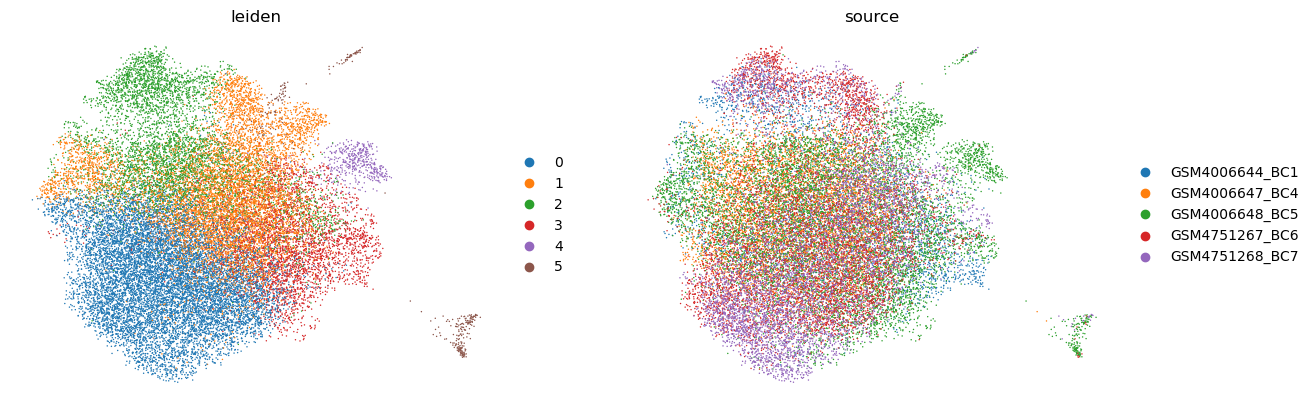

In [15]:
sc.tl.umap(adata_subset)#, min_dist=0.5)
sc.pl.umap(
    adata_subset,
    color=[ "leiden","source",],
    frameon=False,
    ncols=2,
)

In [16]:
adata_subset

AnnData object with n_obs × n_vars = 27864 × 917
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM4751267_BC6', 'total_counts-GSM4751267_BC6', 'Ensemble_ID-GSM4751268

In [17]:
pd.crosstab(adata_subset.obs['leiden'], adata_subset.obs['source'])

source,GSM4006644_BC1,GSM4006647_BC4,GSM4006648_BC5,GSM4751267_BC6,GSM4751268_BC7
leiden,,,,,
0,664,1798,2757,2866,2820
1,825,1916,2270,1508,1280
2,711,1051,1419,1080,661
3,678,334,1307,564,574
4,15,6,411,11,10
5,6,16,226,17,63


In [18]:
indices_t2 = pd.read_csv('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/index_cluster1T2.csv', header=None,index_col=0)

In [19]:
adata_subset.obs['cell_type']= 'None' 

In [20]:
# Now safely assign the new label
for i in indices_t2.index:
    adata_subset.obs.loc[i, 'cell_type'] = 'Cluster1_T2'


In [21]:
adata_subset.obs['cell_type'].astype('category')

AAACCTGAGAAGAAGC.1-GSM4006644_BC1    None
AAACCTGAGCTACCTA.1-GSM4006644_BC1    None
AAACCTGCACGGCGTT.1-GSM4006644_BC1    None
AAACCTGCATCTCGCT.1-GSM4006644_BC1    None
AAACCTGTCAGGCCCA.1-GSM4006644_BC1    None
                                     ... 
TTTGTCAGTACAGACG.1-GSM4751268_BC7    None
TTTGTCAGTCTAGTCA.1-GSM4751268_BC7    None
TTTGTCAGTGGCCCTA.1-GSM4751268_BC7    None
TTTGTCAGTTCTGGTA.1-GSM4751268_BC7    None
TTTGTCATCAACCATG.1-GSM4751268_BC7    None
Name: cell_type, Length: 27864, dtype: category
Categories (2, object): ['Cluster1_T2', 'None']

In [22]:
change_per_cluster_de = model.differential_expression(groupby="cell_type")

DE...:   0%|          | 0/2 [00:00<?, ?it/s]

In [23]:
cell_types = (
    adata_subset.obs["cell_type"]
    .value_counts()
    # .loc[lambda x: (x >= 500) & (x.index != "nan")]
    .loc[lambda x: x.index != "nan"]
    .to_frame("n_cells")
)
cell_types.loc[:, "associated_test"] = cell_types.index.astype(str) + " vs Rest"

In [24]:
cell_types

,n_cells,associated_test
cell_type,,
None,24992,None vs Rest
Cluster1_T2,2872,Cluster1_T2 vs Rest


In [25]:
marker_genes_full = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False)
    ))

/tmp/ipykernel_2375444/624023384.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [30]:
marker_genes_full.to_excel('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/blca_scR_scvi_917_DEG.xlsx')

In [27]:
marker_genes = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False).iloc[:20]
    ))

/tmp/ipykernel_2375444/2561407190.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [28]:
marker_genes

Gene  proba_de  proba_not_de  bayes_factor  \
comparison                                                                
Cluster1_T2 vs Rest 4       UBE2C    0.9822        0.0178      4.010596   
                    105     RAB21    0.9466        0.0534      2.875066   
                    146    CDKN2A    0.9346        0.0654      2.659596   
                    47       FRS2    0.9662        0.0338      3.352910   
                    15      TOP2A    0.9780        0.0220      3.794467   
                    8       BIRC5    0.9808        0.0192      3.933458   
                    1        APOE    0.9850        0.0150      4.184591   
                    6       CCNA2    0.9816        0.0184      3.976833   
                    12      PROS1    0.9790        0.0210      3.842009   
                    5      NUSAP1    0.9820        0.0180      3.999219   
                    13      CDC20    0.9786        0.0214      3.822732   
                    80       MUC1    0.9568        0.0432      3.097754   
                    2       IKZF1    0.9834        0.0166      4.081613   
                    22       CDK1    0.9752        0.0248      3.671799   
                    33     HOMER2    0.9706        0.0294      3.496919   
                    18      AURKB    0.9770        0.0230      3.748992   
                    14      PTPRC    0.9786        0.0214      3.822732   
                    56      CDC42    0.9640        0.0360      3.287572   
                    52      PDGFA    0.9648        0.0352      3.310874   
                    25     SLC1A4    0.9736        0.0264      3.607636   
None vs Rest        937     GATA2    0.9754        0.0246      3.680101   
                    922    IGFBP3    0.9826        0.0174      4.033731   
                    917      MEST    0.9882        0.0118      4.427785   
                    929       APP    0.9790        0.0210      3.842009   
                    920     BNIP3    0.9834        0.0166      4.081613   
                    1004     SNCA    0.9536        0.0464      3.022945   
                    953      GLRX    0.9700        0.0300      3.476098   
                    928   CTNNAL1    0.9792        0.0208      3.851782   
                    935    SLC2A6    0.9756        0.0244      3.688469   
                    944    PRSS23    0.9742        0.0258      3.631242   
                    936      TBX2    0.9754        0.0246      3.680101   
                    984     LOXL1    0.9584        0.0416      3.137165   
                    932     SCRN1    0.9766        0.0234      3.731341   
                    987     SATB1    0.9582        0.0418      3.132160   
                    968       LYN    0.9640        0.0360      3.287572   
                    941     HEBP1    0.9748        0.0252      3.655388   
                    958      RTN2    0.9682        0.0318      3.415972   
                    1034     EDN1    0.9408        0.0592      2.765809   
                    950       FAS    0.9710        0.0290      3.511030   
                    982    PDLIM1    0.9600        0.0400      3.178054   

                            scale1    scale2  pseudocounts  delta  lfc_mean  \
comparison                                                                    
Cluster1_T2 vs Rest 4     0.001418  0.000496           0.0   0.25  5.149887   
                    105   0.019782  0.002156           0.0   0.25  4.855048   
                    146   0.001872  0.000534           0.0   0.25  4.822475   
                    47    0.003166  0.000372           0.0   0.25  4.680283   
                    15    0.000532  0.000189           0.0   0.25  4.530674   
                    8     0.000540  0.000194           0.0   0.25  4.432444   
                    1     0.003322  0.000491           0.0   0.25  4.431330   
                    6     0.000250  0.000070           0.0   0.25  4.426044   
                    12    0.000102  0.000017           0.0   0.25  4.419763   
         